## 05 模型实现

在前面的 Notebook 中，我们已经完成了数据预处理和准备工作。接下来，我们将实现并训练5种不同的机器学习模型，模型复杂度逐步增加，以便比较它们在文本分类任务中的表现。

首先，我们从本地文件中读取数据集，包括分词后的数据集 （`*_seg`）与词元化后的数据集（`*_tok`），以及构建好的词汇表 `vocab`。

In [ ]:
from pandas import DataFrame
from MyModule import load_vocab, load_data

train_seg = load_data('data/train_segmented_final.txt', sep='<sp>', is_segmented=True)
val_seg = load_data('data/val_segmented_final.txt', sep='<sp>', is_segmented=True)
test_seg = load_data('data/test_segmented_final.txt', sep='<sp>', is_segmented=True)

train_tok = load_data('data/train_tokenized_final.txt', sep=',', is_tokenized=True)
val_tok = load_data('data/val_tokenized_final.txt', sep=',', is_tokenized=True)
test_tok = load_data('data/test_tokenized_final.txt', sep=',', is_tokenized=True)

vocab = load_vocab('data/vocab.txt')

### 类别权重（Class Weight）
在 `02Feature Engineering and Data Analysis.ipynb` 中，我们已经观察到数据集标签的分布不平衡情况。在 `03Data Augmentation.ipynb` 中，我们通过回译的方法对训练集进行了数据增强，以缓解类别不平衡的问题。然而，两个定量指标（IR 与 CV）均表明：增强后数据集仍有一定的不平衡性，可能会对模型的训练带来影响。

为了进一步缓解由数据不平衡对模型学习造成的干扰，我们在本 Notebook 中引入类别权重（Class Weight）方法。

类别权重方法是指：在计算损失函数时，为不同类别的样本分配不同的权重，从而使得模型在训练过程中更加关注那些样本较少的类别。具体来说，我们根据每个类别在训练集中的样本数量，计算出每个类别的权重，样本数量越少的类别，其对应的权重越大。下面的代码展示了如何计算类别权重：

In [48]:
import torch

def class_weights(train_data: DataFrame):  #@save
    """计算类别权重，用于损失函数中的加权"""
    label_counts = train_data["label"].value_counts().values
    class_counts = torch.tensor(label_counts, dtype=torch.float)
    weights = torch.sum(class_counts) / (len(class_counts) * class_counts)
    return weights

在后续训练时，只需将经过 `class_weights` 函数计算得到的权重传递给损失函数即可，如：
```python
weights = class_weights(train_seg)
criterion = nn.CrossEntropyLoss(weight=weights)
```

### 损失函数（Loss Function）
为了评估一组参数的好坏，需要有一个准则。在机器学习中，又被称为损失函数（Loss Function）。

简单来说，损失函数用于衡量在训练数据集上模型的输出与真实输出之间的差异。损失函数的值越小，说明模型的预测结果与真实结果越接近，可以认为此时模型表现越好。

在分类任务中，常用的损失函数是交叉熵损失函数（Cross-Entropy Loss）。交叉熵损失函数通过计算预测概率分布与真实标签分布之间的差异来评估模型的性能。其公式如下：
$$
\text{CE} = -\frac1m\sum_{i=1}^m\sum_{j=1}^c y_j^{(i)}\log{\hat{y}_j^{(i)}}
$$

式中，$m$ 表示样本的数量，$c$ 是类别数，$y_j^{(i)}$ 表示第 $i$ 个样本的第 $j$ 类上的真实输出结果，只有正确的类别输出才为 $1$，其他类别输出为 $0$；$\hat{y}_j^{(i)}$ 表示模型对第 $i$ 个样本属于第 $j$ 类的预测概率。

于是，最终交叉熵损失函数只取决于模型对正确类别预测概率的对数值。

模型表现越好，预测的概率越大，由于公式右侧前面还有一个符号，所以交叉熵损失越小（这符合直觉）。

另外，由于交叉熵损失只取决于正确类别的预测结果，所以公式还可以进一步化简：
$$
\text{CE}=-\frac1m\sum_{i=1}^m\log{\hat{y}_t^{(i)}}
$$

式中，$\hat{y}_t^{i}$ 表示模型对第 $i$ 哥样本在正确类别 $t$ 上的预测概率。所以，交叉熵损失也被称为负对数似然损失（Negative Log Likelihood, NNL）。

之所以交叉熵损失的学习速度更高，是因为当模型错误较大时，即对正确类别的预测结果偏小（趋近于 $0$），负对数的值会非常大；而当模型错误较小时，即对正确类别的预测结果偏大（趋近于 $1$），负对数的值会趋近于 $0$。

这种变化呈指数形，即当模型错误较大时，损失函数的梯度较大，因此模型学得更快；当模型错误较小时，损失函数的梯度较小，此时模型学得更慢。

 PyTorch 框架提供了交叉熵损失函数的实现，可以直接使用 `nn.CrossEntropyLoss` 来计算分类任务中的损失值：
 ```python
 criterion = nn.CrossEntropyLoss()
 ```

 如果考虑类别权重，可以传递 `weight` 参数：
 ```python
 criterion = nn.CrossEntropyLoss(weight=weights)
 ```

 然后在训练阶段，调用 `criterion` 来计算损失值即可。
 ```python
 loss = criterion(logits, labels)
 ```
 其中 `logits` 是模型的输出，`labels` 是真实标签。

### 定义通用框架与若干辅助函数
我们使用 PyTorch 框架来实现和训练模型。为了简化代码结构，我们定义了一些通用的辅助函数，包括数据加载、训练循环、评估函数等。这些函数将在后续的模型实现中被反复使用。

#### 1. 模型训练与评估函数
下面的代码定义了一个功能完善的训练和评估函数，用于训练模型并在验证集上评估其性能。

函数不仅包括了基本的训练步骤，还集成了早停（Early Stopping）机制，以防止模型过拟合。

此外，还可以保存训练与验证过程中每个 epoch 的损失和准确率，以便后续分析和可视化。

每次训练都包含以下步骤：
1. 数据预处理：根据不同模型的输入要求，对数据进行相应的处理。
2. 前向传播：将输入数据传入模型，计算输出。
3. 计算损失：使用定义好的损失函数计算预测结果与真实标签之间的误差。
4. 反向传播与优化：根据损失值计算梯度，并更新模型参数。
5. 统计训练指标：计算并记录训练集上的损失和准确率。

每次训练后，将在验证集上评估模型性能，计算并记录验证集上的损失和准确率，以及精确率、召回率和 F1 分数。

```python

In [49]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
import torch.nn as nn
from tqdm.auto import tqdm
import copy 

def train_model_with_validation(  #@save
        model, 
        train_loader, 
        val_loader, 
        optimizer, 
        criterion=nn.CrossEntropyLoss(), 
        num_epochs=10, 
        device=torch.device('cuda'), 
        target_names=['Negative', 'Neutral', 'Positive'],
        patience=3,
        min_delta=0.001
        ):
    """
    通用的模型训练函数，支持验证集评估和早停机制
    
    Args:
        model: PyTorch模型
        train_loader: 训练数据加载器
        val_loader: 验证数据加载器 (可选)
        criterion: 损失函数
        optimizer: 优化器
        num_epochs: 训练轮数
        device: 设备 (cpu/cuda)
        target_names: 类别名称列表
        patience: 早停耐心值，验证损失不下降的最大轮数
        min_delta: 最小改善阈值，小于此值视为没有改善
        
    Returns:
        dict: 包含训练历史的字典
    """
    
    # 训练历史记录
    history = {
        'train_losses': [],
        'train_accuracies': [],
        'val_losses': [],
        'val_accuracies': [],
        'val_f1_scores': [],
        'val_precision_scores': [],
        'val_recall_scores': []
    }
    
    # 早停相关变量
    if patience is not None and val_loader is not None:
        best_val_loss = float('inf')
        patience_counter = 0
        best_model_state = None
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()  # 设置为训练模式
        total_train_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            # 1. 数据预处理：根据不同模型，处理输入格式
            # 关于每种模型的输入模式，将在后续章节中详细介绍
            if len(batch) == 2:  # CNN
                inputs, targets = batch
                inputs, targets = inputs.to(device), targets.to(device)
                logits = model(inputs)
            elif len(batch) == 3:  # MLP, LSTM and Transformer
                if hasattr(model, 'embeddingbag'):  # MLP
                    inputs, offsets, targets = [x.to(device) for x in batch]
                    logits = model(inputs, offsets)
                else:  # LSTM, Transformer
                    inputs, lengths, targets = batch
                    inputs, targets = inputs.to(device), targets.to(device)
                    logits = model(inputs, lengths)
            
            # 2. 前向传播
            loss = criterion(logits, targets)

            # 3. 反向传播
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # 4. 统计训练指标
            total_train_loss += loss.item()
            preds = logits.argmax(dim=1)
            train_correct += (preds == targets).sum().item()
            train_total += targets.size(0)
        
        # 记录训练指标
        avg_train_loss = total_train_loss / len(train_loader)
        train_acc = train_correct / train_total
        history['train_losses'].append(avg_train_loss)
        history['train_accuracies'].append(train_acc)
        
        # 验证阶段
        if val_loader is not None:
            val_metrics = evaluate_model(model, val_loader, criterion, device)

            # 记录验证指标
            history['val_losses'].append(val_metrics['loss'])
            history['val_accuracies'].append(val_metrics['accuracy'])
            history['val_f1_scores'].append(val_metrics['f1'])
            history['val_precision_scores'].append(val_metrics['precision'])
            history['val_recall_scores'].append(val_metrics['recall'])
            
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"    Train Loss: {avg_train_loss:.4f}\tTrain Accuracy: {train_acc:.4f}")
            print(f"    Valid Loss: {val_metrics['loss']:.4f}\tValid Accuracy: {val_metrics['accuracy']:.4f}")
            print(f"    Valid Precision: {val_metrics['precision']:.4f}\tValid Recall: {val_metrics['recall']:.4f}\tValid F1: {val_metrics['f1']:.4f}")
            
            # 早停检查
            if patience is not None:
                current_val_loss = val_metrics['loss']
                # 如果验证损失有改善，重置耐心计数器
                if current_val_loss < best_val_loss - min_delta:
                    best_val_loss = current_val_loss
                    patience_counter = 0
                    best_model_state = copy.deepcopy(model.state_dict())
                    print(f"    ✓ New best validation loss: {best_val_loss:.4f}")

                # 否则，增加耐心计数器
                else:
                    patience_counter += 1
                    print(f"    No improvement. Patience: {patience_counter}/{patience}")

                # 如果耐心计数器达到上限，停止训练
                if patience_counter >= patience:
                    print(f"    Early stopping triggered! Best validation loss: {best_val_loss:.4f}")
                    model.load_state_dict(best_model_state)
                    break
            
            print('-' * 80)
            
            # 最后一个epoch打印详细报告
            if epoch == num_epochs - 1:
                print("\nDetailed Classification Report:")
                print(classification_report(val_metrics['true_labels'], val_metrics['pred_labels'], 
                                          target_names=target_names, digits=4))
        else:
            print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_train_loss:.4f} - Accuracy: {train_acc:.4f}")
    
    # 添加早停信息到历史记录
    if patience is not None and val_loader is not None:
        history['early_stopped'] = patience_counter >= patience
        history['best_val_loss'] = best_val_loss
        history['stopped_epoch'] = epoch + 1 if patience_counter >= patience else num_epochs
    
    return history


def evaluate_model(  #@save
        model, 
        data_loader, 
        criterion=nn.CrossEntropyLoss(), 
        device=torch.device('cuda')
        ):
    """
    通用的模型评估函数
    
    Args:
        model: PyTorch模型
        data_loader: 数据加载器
        criterion: 损失函数
        device: 设备
        
    Returns:
        dict: 评估结果字典
    """
    model.eval()  # 设置为评估模式
    total_loss = 0
    all_preds = []
    all_targets = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in data_loader:
            # 处理不同模型的输入格式
            if len(batch) == 2:  # CNN, basic models
                inputs, targets = batch
                inputs, targets = inputs.to(device), targets.to(device)
                logits = model(inputs)
            elif len(batch) == 3:  # MLP, LSTM, Transformer
                if hasattr(model, 'embeddingbag'):  # MLP
                    inputs, offsets, targets = [x.to(device) for x in batch]
                    logits = model(inputs, offsets)
                else:  # LSTM, Transformer
                    inputs, lengths, targets = batch
                    inputs, targets = inputs.to(device), targets.to(device)
                    logits = model(inputs, lengths)
            
            loss = criterion(logits, targets)
            total_loss += loss.item()
            
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            correct += (preds == targets).sum().item()
            total += targets.size(0)
    
    # 计算指标
    accuracy = correct / total
    avg_loss = total_loss / len(data_loader)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_targets, all_preds, average='weighted', zero_division=0
    )
    
    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'true_labels': all_targets,
        'pred_labels': all_preds
    }

#### 2. 模型测试函数
在模型训练完成后，我们需要在测试集上评估模型的最终性能。下面的代码定义了一个全面的测试函数，用于在测试集上计算模型的各项指标。

测试函数包括以下步骤：
1. 设置模型为评估模式：禁用梯度计算
2. 前向传播：在训练好的模型上运行测试数据，计算输出
3. 计算损失和各项指标：包括准确率、精确率、召回率和 F1 分数等

In [50]:
def test_model_comprehensive(  #@save
        model, 
        model_name, 
        test_loader, 
        device=torch.device('cuda'), 
        target_names=['Negative', 'Neutral', 'Positive']
        ):
    """
    全面的模型测试函数，包含F1分数和混淆矩阵
    
    Args:
        model: PyTorch模型
        model_name: 模型名称
        test_loader: 测试数据加载器
        device: 设备
        target_names: 类别名称列表
        
    Returns:
        dict: 测试结果字典
    """
    model.eval()
    all_preds = []
    all_targets = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            # 处理不同模型的输入格式
            if len(batch) == 2:
                inputs, targets = batch
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
            elif len(batch) == 3:
                if hasattr(model, 'embeddingbag'):  # MLP
                    inputs, offsets, targets = [x.to(device) for x in batch]
                    outputs = model(inputs, offsets)
                else:  # LSTM, Transformer
                    inputs, lengths, targets = batch
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs, lengths)
            
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            correct += (preds == targets).sum().item()
            total += targets.size(0)
    
    # 计算指标
    test_accuracy = correct / total
    test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
        all_targets, all_preds, average='weighted', zero_division=0
    )
    
    # 计算每个类别的指标
    class_precision, class_recall, class_f1, class_support = precision_recall_fscore_support(
        all_targets, all_preds, average=None, zero_division=0
    )
    
    # 输出结果
    print("\n" + "="*80)
    print("TEST RESULTS")
    print("="*80)
    print(f"Model Name: {model_name}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision (weighted): {test_precision:.4f}")
    print(f"Test Recall (weighted): {test_recall:.4f}")
    print(f"Test F1 Score (weighted): {test_f1:.4f}")
    
    # 详细分类报告
    print("\nDetailed Test Classification Report:")
    print(classification_report(all_targets, all_preds, target_names=target_names, digits=4))
    
    # 绘制混淆矩阵
    plot_confusion_matrix(model_name, all_targets, all_preds, target_names)

    # 打印每个类别的指标
    print("\nPer-Class Metrics:")
    print("-" * 60)
    for i, class_name in enumerate(target_names):
        print(f"{class_name:>8}: Precision={class_precision[i]:.4f}, "
              f"Recall={class_recall[i]:.4f}, F1={class_f1[i]:.4f}, "
              f"Support={int(class_support[i])}")
    
    return {
        'accuracy': test_accuracy,
        'precision': test_precision,
        'recall': test_recall,
        'f1': test_f1,
        'class_metrics': {
            'precision': class_precision,
            'recall': class_recall,
            'f1': class_f1,
            'support': class_support
        }
    }

#### 3. 绘图函数
为了更直观地展示模型的训练过程和性能，我们定义了两个绘图函数 `plot_training_curves` 和 `plot_confusion_matrix`，前者用于绘制训练和验证的损失与准确率曲线以及过拟合监控曲线，后者用于绘制测试阶段的混淆矩阵。

函数支持在 Notebook 中显示，也支持保存至本地文件。

In [51]:
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os


def plot_training_curves(model_name, history, save_path="results/pics/training_curves"):  #@save
    """绘制训练曲线"""
    num_epochs = len(history['train_losses'])
    
    plt.figure(figsize=(15, 5))
    
    # 训练损失和准确率
    plt.subplot(1, 2, 1)
    epochs_range = range(1, num_epochs+1)
    plt.plot(epochs_range, history['train_losses'], 'b--', label='Train Loss', linewidth=2)
    plt.plot(epochs_range, history['train_accuracies'], 'r-', label='Train Acc', linewidth=2)
    if history['val_accuracies']:
        plt.plot(epochs_range, history['val_accuracies'], 'g-', label='Val Acc', linewidth=2)
    
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title(f'Training Loss & Accuracy - {model_name}')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.xlim(1, 10)
    plt.ylim(0, 1.0)
    
    # 设置x轴刻度为整数
    plt.xticks(epochs_range)
    
    # 过拟合监控
    if history['val_accuracies']:
        plt.subplot(1, 2, 2)
        acc_diff = [train_acc - val_acc for train_acc, val_acc in 
                   zip(history['train_accuracies'], history['val_accuracies'])]
        plt.plot(epochs_range, acc_diff, 'purple', label='Train - Val Accuracy', linewidth=2)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy Difference')
        plt.title(f'Overfitting Monitor - {model_name}')
        plt.xlim(1, 10)
        plt.ylim(-0.2, 0.5)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
        
        # 设置x轴刻度为整数
        plt.xticks(epochs_range)
    
    plt.tight_layout()
    if save_path:
        time = datetime.now().strftime("%Y%m%d_%H%M%S")
        pic_name = f"{time}_{model_name.replace(' ', '_').lower()}.png"
        plt.savefig(os.path.join(save_path, pic_name), dpi=300, bbox_inches='tight')
    plt.show()


def plot_confusion_matrix(model_name, true_labels, pred_labels, target_names, save_path="results/pics/confusion_matrix"):  #@save
    """绘制规范化混淆矩阵"""
    plt.figure(figsize=(8, 6))
    
    cm = confusion_matrix(true_labels, pred_labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names,
                cbar_kws={'label': 'Proportion'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    
    plt.tight_layout()
    if save_path:
        time = datetime.now().strftime("%Y%m%d_%H%M%S")
        pic_name = f"{time}_{model_name.replace(' ', '_').lower()}.png"
        plt.savefig(os.path.join(save_path, pic_name), dpi=300, bbox_inches='tight')
    plt.show()

#### 4. 其他辅助函数
此外，我们还定义了一些其他辅助函数，例如用于打印训练摘要的函数 `print_training_summary` 和保存训练结果的函数 `save_training_results` 等。

In [52]:
import numpy as np
from tqdm.auto import tqdm
import json


def print_training_summary(model_name, history):  #@save
    """打印训练摘要"""
    print("\n" + "="*60)
    print("TRAINING SUMMARY")
    print("="*60)
    print(f"Model Name: {model_name}")
    print(f"Final Train Loss: {history['train_losses'][-1]:.4f}")
    print(f"Final Train Accuracy: {history['train_accuracies'][-1]:.4f}")
    
    if history['val_accuracies']:
        print(f"Final Val Loss: {history['val_losses'][-1]:.4f}")
        print(f"Final Val Accuracy: {history['val_accuracies'][-1]:.4f}")
        print(f"Best Val Accuracy: {max(history['val_accuracies']):.4f} (Epoch {history['val_accuracies'].index(max(history['val_accuracies']))+1})")
        print(f"Final Overfitting Gap: {history['train_accuracies'][-1] - history['val_accuracies'][-1]:.4f}")


def convert_numpy_to_python(obj):  #@save
    """
    递归地将NumPy数组和其他不可JSON序列化的对象转换为Python原生类型
    """
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, dict):
        return {key: convert_numpy_to_python(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_to_python(item) for item in obj]
    elif isinstance(obj, tuple):
        return tuple(convert_numpy_to_python(item) for item in obj)
    else:
        return obj

def save_training_results(  #@save
    model, 
    model_name, 
    set_epochs,
    actual_epochs, 
    device, 
    use_pretrained_embeddings, 
    training_history, 
    test_results, 
    save_path="results/model_training_results.json"
):
    """
    保存模型训练结果到JSON文件
    
    Args:
        model: PyTorch模型实例
        model_name: 模型名称字符串
        actual_epochs: 实际训练的迭代次数
        device: 训练设备 (torch.device 或字符串)
        use_pretrained_embeddings: 是否使用预训练词向量 (布尔值)
        training_history: 训练历史字典 (包含losses, accuracies等)
        test_results: 测试结果字典 (包含accuracy, f1等指标)
        save_path: JSON文件保存路径
    
    """
    
    # 深拷贝并转换数据类型
    training_history_cleaned = convert_numpy_to_python(copy.deepcopy(training_history))
    training_history_cleaned = {k: v for k, v in training_history_cleaned.items() if k not in ["val_f1_scores", "val_precision_scores", "val_recall_scores"]}
      # 移除空条目
    test_results_cleaned = convert_numpy_to_python(copy.deepcopy(test_results))
    test_results_cleaned = {k: v for k, v in test_results_cleaned.items() if k != "class_metrics"}  # 移除空条目
    
    # 提取模型结构信息
    model_structure = [str(module) for module in model.children()]  # 获取模型的字符串表示
    
    # 获取模型的详细配置信息
    model_config = {
        "total_parameters": sum(p.numel() for p in model.parameters()),
        "trainable_parameters": sum(p.numel() for p in model.parameters() if p.requires_grad),
        "model_structure": model_structure,
    }
    
    # 创建当前训练记录
    current_record = {
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "model_class": model.__class__.__name__,
        "model_name": model_name,
        "model_config": model_config, 
        "set_epochs": set_epochs, 
        "actual_epochs": actual_epochs,
        "device": str(device),
        "use_pretrained_embeddings": use_pretrained_embeddings,
        "training_history": training_history_cleaned,
        "test_results": test_results_cleaned,
    }
    
    # 读取现有的JSON文件或创建新的记录列表
    if os.path.exists(save_path):
        try:
            with open(save_path, 'r', encoding='utf-8') as f:
                existing_records = json.load(f)
                
            # 确保现有数据是列表格式
            if not isinstance(existing_records, list):
                existing_records = [existing_records] if existing_records else []
                
        except (json.JSONDecodeError, FileNotFoundError):
            print(f"警告: 无法读取现有文件 {save_path}，创建新文件")
            existing_records = []
    else:
        existing_records = []
    
    # 添加当前记录
    existing_records.append(current_record)
    
    # 保存更新后的记录列表
    try:
        with open(save_path, 'w', encoding='utf-8') as f:
            json.dump(existing_records, f, ensure_ascii=False, indent=2)
        
        print(f"✓ 训练结果已保存到 {save_path}")
        print(f"  - 模型: {model_name} ({model.__class__.__name__})")
        print(f"  - 实际训练轮数: {actual_epochs}")
        print(f"  - 测试准确率: {test_results.get('accuracy', 'N/A'):.4f}")
        print(f"  - 测试F1分数: {test_results.get('f1', 'N/A'):.4f}")
        print(f"  - 记录时间: {current_record['timestamp']}")
        print(f"  - 总记录数: {len(existing_records)}")
        
    except Exception as e:
        print(f"错误: 保存文件时出现问题: {e}")
        return None
    
    # return current_record

def load_training_results(save_path="results/model_training_results.json"):  #@save
    """
    加载训练结果记录
    
    Args:
        save_path: JSON文件路径
    
    Returns:
        list: 训练结果记录列表
    """
    if not os.path.exists(save_path):
        print(f"文件 {save_path} 不存在")
        return []
    
    try:
        with open(save_path, 'r', encoding='utf-8') as f:
            records = json.load(f)
        
        if not isinstance(records, list):
            records = [records] if records else []
            
        print(f"✓ 成功加载 {len(records)} 条训练记录")
        return records
        
    except json.JSONDecodeError as e:
        print(f"错误: JSON文件格式错误: {e}")
        return []
    except Exception as e:
        print(f"错误: 加载文件时出现问题: {e}")
        return []

以上定义的通用框架和辅助函数将为后续的模型实现和训练提供便利，使得代码结构更加清晰，易于维护和扩展。在接下来的部分中，我们将使用这些函数来实现和训练不同的机器学习模型。

### TF-IDF + 逻辑回归

In [53]:
# TF-IDF 特征化并构建 PyTorch Dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from pandas import DataFrame, Series


train_texts = [' '.join(word) for word in train_seg["text"]]
val_texts = [' '.join(word) for word in val_seg["text"]]
test_texts = [' '.join(word) for word in test_seg["text"]]

train_labels = train_seg["label"]
val_labels = val_seg["label"]
test_labels = test_seg["label"]

max_features = 50000

# 使用 TF-IDF 向量化（限制特征数以控制内存）
vectorizer = TfidfVectorizer(max_features=max_features, tokenizer=lambda x: x.split())
X_train = vectorizer.fit_transform(train_texts)
X_val = vectorizer.transform(val_texts)
X_test = vectorizer.transform(test_texts)

# 将稀疏矩阵包装为 Dataset
class SparseTfidfDataset(Dataset):
    def __init__(self, X: sparse.spmatrix, y: Series):
        self.X = X
        self.y = y
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        row = self.X.getrow(idx).toarray().squeeze(0)  # 转为稠密向量（内存可控时使用）
        return torch.from_numpy(row).float(), torch.tensor(self.y[idx], dtype=torch.long)

# 使用 PyTorch 实现的 Logistic Regression
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, num_class):
        super().__init__()
        self.linear = torch.nn.Linear(input_dim, num_class)
    def forward(self, x):
        return self.linear(x)

e:\anaconda3\envs\nlpllma\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [54]:
num_class = 3
batch_size = 32
num_epoch = 10
input_dim = max_features
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset_tfidf = SparseTfidfDataset(X_train, train_labels)
val_dataset_tfidf = SparseTfidfDataset(X_val, val_labels)
test_dataset_tfidf = SparseTfidfDataset(X_test, test_labels)

train_data_loader_tfidf = DataLoader(train_dataset_tfidf, batch_size=batch_size, shuffle=True)
val_data_loader_tfidf = DataLoader(val_dataset_tfidf, batch_size=batch_size, shuffle=False)
test_data_loader_tfidf = DataLoader(test_dataset_tfidf, batch_size=1, shuffle=False)

# 计算类别权重
weights = class_weights(train_seg)

# 初始化模型、优化器与损失函数
logreg = LogisticRegression(input_dim, num_class).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = torch.optim.Adam(logreg.parameters(), lr=0.001)

In [55]:
logreg_history = train_model_with_validation(
    model=logreg,
    train_loader=train_data_loader_tfidf,
    val_loader=val_data_loader_tfidf,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=num_epoch,
    device=device, 
    )

Training Epoch 1: 100%|██████████| 8572/8572 [01:30<00:00, 95.09it/s] 


Epoch 1/10
    Train Loss: 0.7873	Train Accuracy: 0.5964
    Valid Loss: 0.6831	Valid Accuracy: 0.6832
    Valid Precision: 0.7082	Valid Recall: 0.6832	Valid F1: 0.6682
    ✓ New best validation loss: 0.6831
--------------------------------------------------------------------------------


Training Epoch 2: 100%|██████████| 8572/8572 [01:27<00:00, 97.60it/s] 


Epoch 2/10
    Train Loss: 0.6299	Train Accuracy: 0.7225
    Valid Loss: 0.6265	Valid Accuracy: 0.7187
    Valid Precision: 0.7258	Valid Recall: 0.7187	Valid F1: 0.7118
    ✓ New best validation loss: 0.6265
--------------------------------------------------------------------------------


Training Epoch 3: 100%|██████████| 8572/8572 [01:28<00:00, 97.36it/s] 


Epoch 3/10
    Train Loss: 0.5799	Train Accuracy: 0.7486
    Valid Loss: 0.6029	Valid Accuracy: 0.7290
    Valid Precision: 0.7336	Valid Recall: 0.7290	Valid F1: 0.7241
    ✓ New best validation loss: 0.6029
--------------------------------------------------------------------------------


Training Epoch 4: 100%|██████████| 8572/8572 [01:27<00:00, 97.46it/s] 


Epoch 4/10
    Train Loss: 0.5515	Train Accuracy: 0.7625
    Valid Loss: 0.5906	Valid Accuracy: 0.7350
    Valid Precision: 0.7379	Valid Recall: 0.7350	Valid F1: 0.7310
    ✓ New best validation loss: 0.5906
--------------------------------------------------------------------------------


Training Epoch 5: 100%|██████████| 8572/8572 [01:27<00:00, 97.57it/s] 


Epoch 5/10
    Train Loss: 0.5320	Train Accuracy: 0.7713
    Valid Loss: 0.5834	Valid Accuracy: 0.7376
    Valid Precision: 0.7403	Valid Recall: 0.7376	Valid F1: 0.7338
    ✓ New best validation loss: 0.5834
--------------------------------------------------------------------------------


Training Epoch 6: 100%|██████████| 8572/8572 [01:28<00:00, 97.37it/s] 


Epoch 6/10
    Train Loss: 0.5175	Train Accuracy: 0.7786
    Valid Loss: 0.5793	Valid Accuracy: 0.7393
    Valid Precision: 0.7417	Valid Recall: 0.7393	Valid F1: 0.7359
    ✓ New best validation loss: 0.5793
--------------------------------------------------------------------------------


Training Epoch 7: 100%|██████████| 8572/8572 [01:28<00:00, 97.26it/s] 


Epoch 7/10
    Train Loss: 0.5056	Train Accuracy: 0.7840
    Valid Loss: 0.5773	Valid Accuracy: 0.7417
    Valid Precision: 0.7430	Valid Recall: 0.7417	Valid F1: 0.7380
    ✓ New best validation loss: 0.5773
--------------------------------------------------------------------------------


Training Epoch 8: 100%|██████████| 8572/8572 [01:27<00:00, 97.42it/s] 


Epoch 8/10
    Train Loss: 0.4959	Train Accuracy: 0.7883
    Valid Loss: 0.5763	Valid Accuracy: 0.7434
    Valid Precision: 0.7444	Valid Recall: 0.7434	Valid F1: 0.7408
    ✓ New best validation loss: 0.5763
--------------------------------------------------------------------------------


Training Epoch 9: 100%|██████████| 8572/8572 [01:27<00:00, 98.03it/s] 


Epoch 9/10
    Train Loss: 0.4878	Train Accuracy: 0.7919
    Valid Loss: 0.5762	Valid Accuracy: 0.7430
    Valid Precision: 0.7445	Valid Recall: 0.7430	Valid F1: 0.7397
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 10: 100%|██████████| 8572/8572 [01:30<00:00, 94.48it/s] 


Epoch 10/10
    Train Loss: 0.4807	Train Accuracy: 0.7953
    Valid Loss: 0.5767	Valid Accuracy: 0.7430
    Valid Precision: 0.7446	Valid Recall: 0.7430	Valid F1: 0.7402
    No improvement. Patience: 2/3
--------------------------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative     0.8115    0.6997    0.7514     18650
     Neutral     0.6722    0.6083    0.6386     14956
    Positive     0.7381    0.8552    0.7923     25167

    accuracy                         0.7430     58773
   macro avg     0.7406    0.7210    0.7275     58773
weighted avg     0.7446    0.7430    0.7402     58773



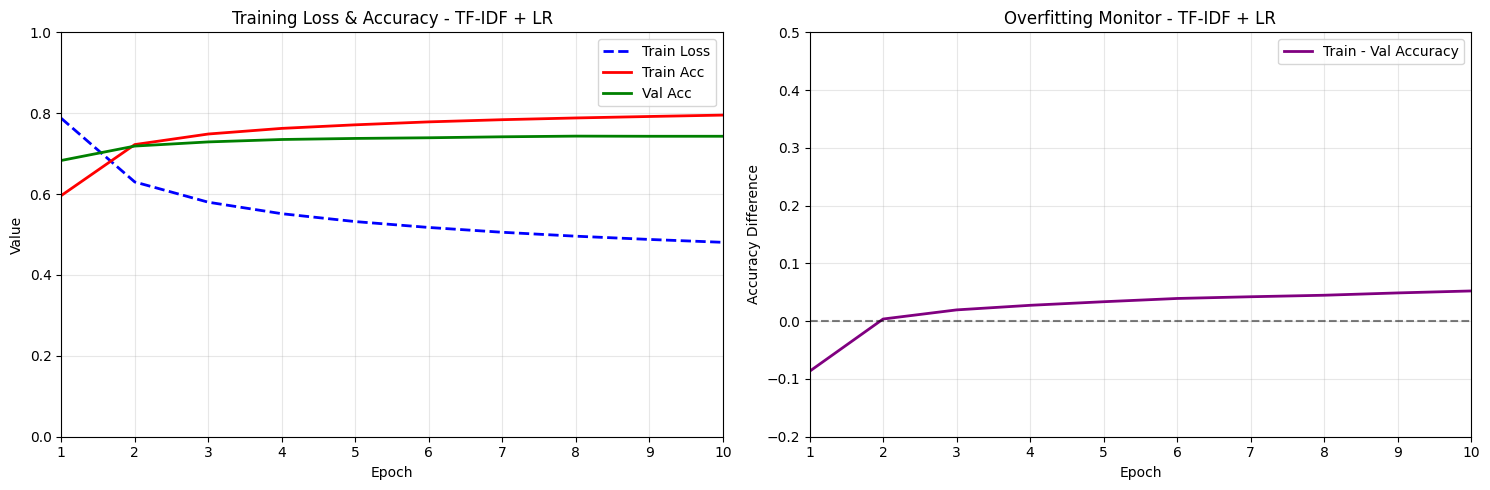


TRAINING SUMMARY
Model Name: TF-IDF + LR
Final Train Loss: 0.4807
Final Train Accuracy: 0.7953
Final Val Loss: 0.5767
Final Val Accuracy: 0.7430
Best Val Accuracy: 0.7434 (Epoch 8)
Final Overfitting Gap: 0.0523


In [56]:
# 绘制训练曲线
plot_training_curves("TF-IDF + LR", logreg_history)

# 打印训练摘要
print_training_summary("TF-IDF + LR", logreg_history)

Testing: 100%|██████████| 58773/58773 [00:57<00:00, 1027.17it/s]



TEST RESULTS
Model Name: TF-IDF + LR
Test Accuracy: 0.7470
Test Precision (weighted): 0.7483
Test Recall (weighted): 0.7470
Test F1 Score (weighted): 0.7443

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.8140    0.7098    0.7583     18650
     Neutral     0.6765    0.6073    0.6400     14956
    Positive     0.7422    0.8577    0.7958     25167

    accuracy                         0.7470     58773
   macro avg     0.7442    0.7249    0.7314     58773
weighted avg     0.7483    0.7470    0.7443     58773



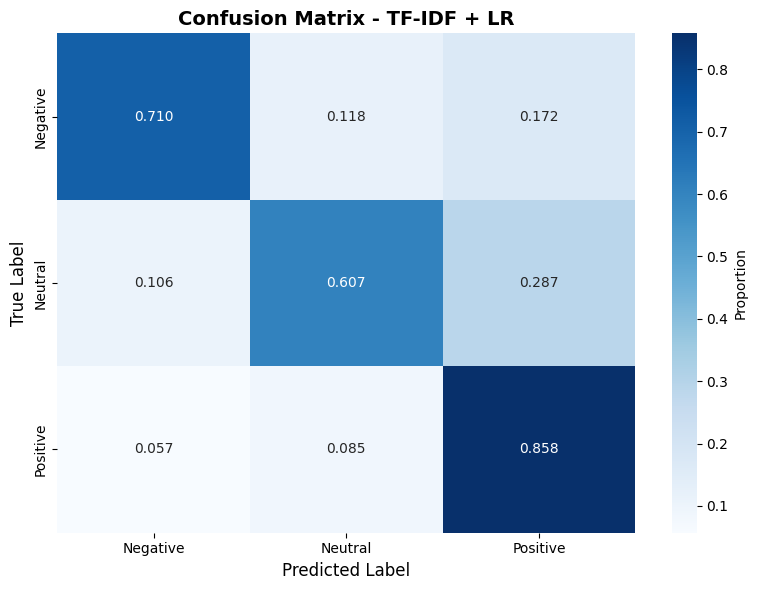


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.8140, Recall=0.7098, F1=0.7583, Support=18650
 Neutral: Precision=0.6765, Recall=0.6073, F1=0.6400, Support=14956
Positive: Precision=0.7422, Recall=0.8577, F1=0.7958, Support=25167


In [57]:
logreg_test_results = test_model_comprehensive(
    model=logreg,
    model_name="TF-IDF + LR",
    test_loader=test_data_loader_tfidf,
    device=device,
    target_names=['Negative', 'Neutral', 'Positive']
)

In [58]:
save_training_results(
    model=logreg,
    model_name="TF-IDF + LR",
    set_epochs=num_epoch,
    actual_epochs=len(logreg_history['train_losses']),
    device=device,
    use_pretrained_embeddings=False,
    training_history=logreg_history,
    test_results=logreg_test_results,
)

✓ 训练结果已保存到 results/model_training_results.json
  - 模型: TF-IDF + LR (LogisticRegression)
  - 实际训练轮数: 10
  - 测试准确率: 0.7470
  - 测试F1分数: 0.7443
  - 记录时间: 2025-11-16 22:42:46
  - 总记录数: 16


### 多层感知机

In [59]:
from torch.utils.data import Dataset, DataLoader

# 构建数据集类和数据整理函数
class BowDataset(Dataset):  #@save
    def __init__(self, data: DataFrame) -> None:
        self.data = data

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, i: int):
        return self.data.iloc[i]

def collate_fn_mlp(batch):  #@save
    # 从独立样本集合中构建各批次的输入输出
    # 其中 BowDataset 类定义了一个样本的数据结构，即输入标签和输出标签的元组
    # 因此，将输入 inputs 定义为一个张量的列表，其中每个张量为原始句子中词元序列对应的索引值序列
    inputs = [torch.tensor(b["text"]) for b in batch]

    # 输出的目标 targets 为该批次中由全部样例输出结果构成的张量
    targets = torch.tensor([b["label"] for b in batch], dtype=torch.long)

    # 获取一个批次中每个样例的序列长度
    offsets = [0] + [i.shape[0] for i in inputs]

    # 根据序列的长度，转换为每个序列起始位置的偏移量
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)

    # 将 inputs 列表中的张量拼接成一个大的张量
    inputs = torch.cat(inputs)

    return inputs, offsets, targets

In [60]:
from torch.nn import functional as F

class MLP(nn.Module):  #@save
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_class, 
                 pretrained_embedding_matrix=None, freeze=True):
        super(MLP, self).__init__()

        # EmbeddingBag 层
        if pretrained_embedding_matrix is not None:
            self.embeddingbag = nn.EmbeddingBag.from_pretrained(pretrained_embedding_matrix, freeze=freeze, mode="mean")
        else:
            self.embeddingbag = nn.EmbeddingBag(vocab_size, embedding_dim)


        # 线性变换：词向量层 -> 隐含层
        self.linear1 = nn.Linear(embedding_dim, hidden_dim)

        # 使用ReLU激活函数
        self.activate = F.relu

        # 线性变换：激活层 -> 输出层
        self.linear2 = nn.Linear(hidden_dim, num_class)

        self.dropout = nn.Dropout(0.5)
    
    def forward(self, inputs, offsets):
        embedding = self.embeddingbag(inputs, offsets)
        hidden = self.activate(self.linear1(embedding))
        hidden = self.dropout(hidden)
        outputs = self.linear2(hidden)
        return outputs

In [61]:
# 超参数设置
embedding_dim = 200
num_class = 3
hidden_dim = 256
batch_size = 32
num_epoch = 10

# 加载数据
train_dataset = BowDataset(train_tok)
val_dataset = BowDataset(val_tok)
test_dataset = BowDataset(test_tok)

train_data_loader_mlp = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_mlp, shuffle=True)
val_data_loader_mlp = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_mlp, shuffle=False)
test_data_loader_mlp = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_mlp, shuffle=False)

# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp = MLP(len(vocab), embedding_dim, hidden_dim, num_class)
mlp.to(device)

MLP(
  (embeddingbag): EmbeddingBag(35366, 200, mode='mean')
  (linear1): Linear(in_features=200, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [62]:


# MLP 训练过程 - 使用通用框架
weights = class_weights(train_tok)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)

# 使用通用训练函数
mlp_history = train_model_with_validation(
    model=mlp,
    train_loader=train_data_loader_mlp,
    val_loader=val_data_loader_mlp,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device,
)

Training Epoch 1: 100%|██████████| 8533/8533 [00:34<00:00, 246.55it/s]


Epoch 1/10
    Train Loss: 0.7032	Train Accuracy: 0.6747
    Valid Loss: 0.6212	Valid Accuracy: 0.7172
    Valid Precision: 0.7225	Valid Recall: 0.7172	Valid F1: 0.7108
    ✓ New best validation loss: 0.6212
--------------------------------------------------------------------------------


Training Epoch 2: 100%|██████████| 8533/8533 [00:34<00:00, 249.88it/s]


Epoch 2/10
    Train Loss: 0.5804	Train Accuracy: 0.7453
    Valid Loss: 0.5983	Valid Accuracy: 0.7395
    Valid Precision: 0.7379	Valid Recall: 0.7395	Valid F1: 0.7356
    ✓ New best validation loss: 0.5983
--------------------------------------------------------------------------------


Training Epoch 3: 100%|██████████| 8533/8533 [00:35<00:00, 237.68it/s]


Epoch 3/10
    Train Loss: 0.5373	Train Accuracy: 0.7681
    Valid Loss: 0.5945	Valid Accuracy: 0.7381
    Valid Precision: 0.7406	Valid Recall: 0.7381	Valid F1: 0.7317
    ✓ New best validation loss: 0.5945
--------------------------------------------------------------------------------


Training Epoch 4: 100%|██████████| 8533/8533 [00:35<00:00, 243.72it/s]


Epoch 4/10
    Train Loss: 0.5093	Train Accuracy: 0.7809
    Valid Loss: 0.5988	Valid Accuracy: 0.7462
    Valid Precision: 0.7449	Valid Recall: 0.7462	Valid F1: 0.7436
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 5: 100%|██████████| 8533/8533 [00:34<00:00, 247.69it/s]


Epoch 5/10
    Train Loss: 0.4873	Train Accuracy: 0.7912
    Valid Loss: 0.6119	Valid Accuracy: 0.7371
    Valid Precision: 0.7435	Valid Recall: 0.7371	Valid F1: 0.7279
    No improvement. Patience: 2/3
--------------------------------------------------------------------------------


Training Epoch 6: 100%|██████████| 8533/8533 [00:35<00:00, 240.74it/s]


Epoch 6/10
    Train Loss: 0.4671	Train Accuracy: 0.8010
    Valid Loss: 0.6153	Valid Accuracy: 0.7478
    Valid Precision: 0.7468	Valid Recall: 0.7478	Valid F1: 0.7422
    No improvement. Patience: 3/3
    Early stopping triggered! Best validation loss: 0.5945


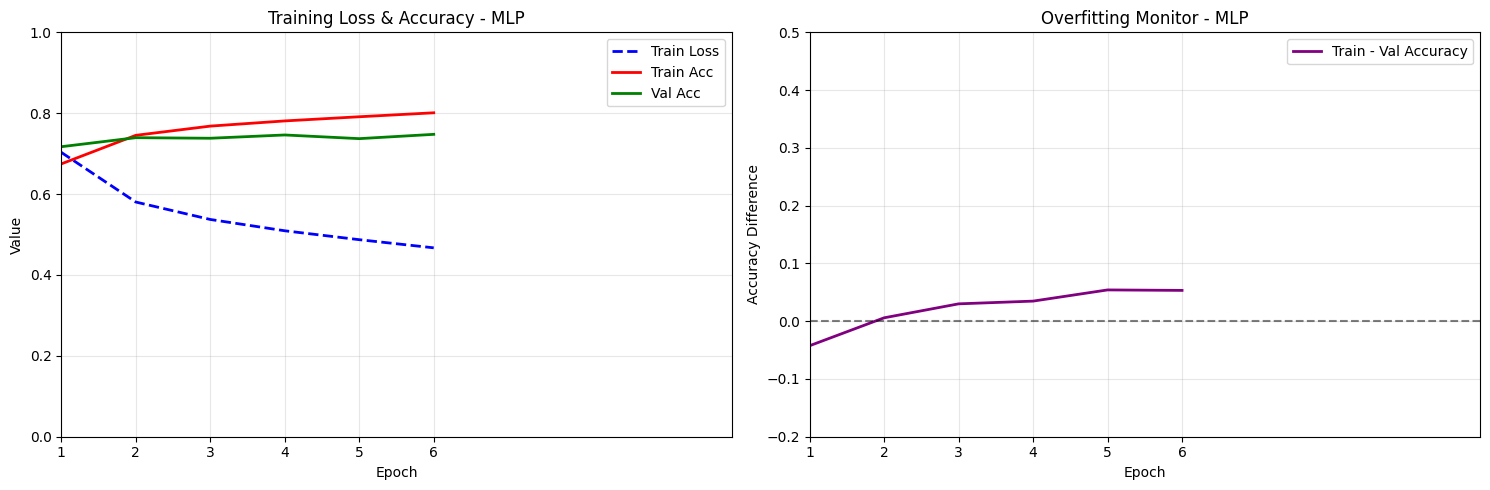


TRAINING SUMMARY
Model Name: MLP
Final Train Loss: 0.4671
Final Train Accuracy: 0.8010
Final Val Loss: 0.6153
Final Val Accuracy: 0.7478
Best Val Accuracy: 0.7478 (Epoch 6)
Final Overfitting Gap: 0.0533


In [63]:
# 绘制训练曲线
plot_training_curves("MLP", mlp_history)

# 打印训练摘要
print_training_summary("MLP", mlp_history)

Testing: 100%|██████████| 58491/58491 [00:44<00:00, 1309.96it/s]



TEST RESULTS
Model Name: MLP
Test Accuracy: 0.7398
Test Precision (weighted): 0.7418
Test Recall (weighted): 0.7398
Test F1 Score (weighted): 0.7332

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.7962    0.7268    0.7599     18596
     Neutral     0.7145    0.5242    0.6047     14754
    Positive     0.7176    0.8761    0.7890     25141

    accuracy                         0.7398     58491
   macro avg     0.7428    0.7090    0.7179     58491
weighted avg     0.7418    0.7398    0.7332     58491



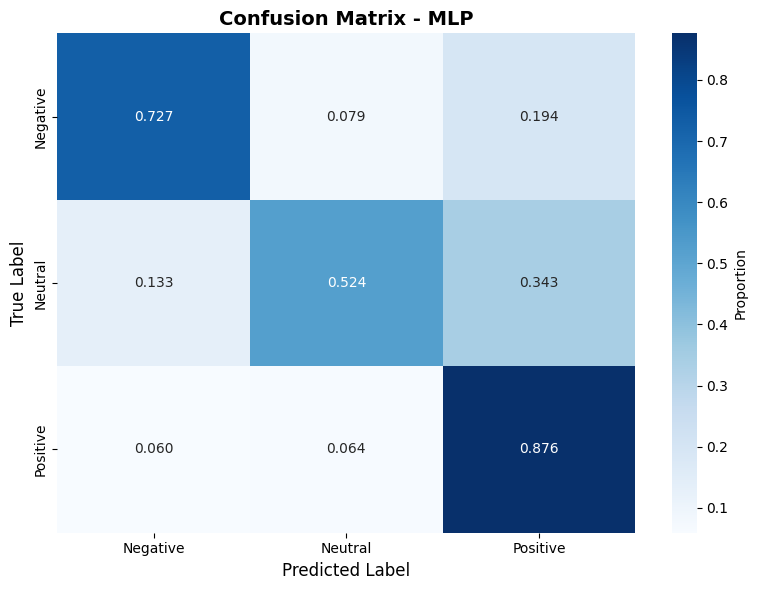


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.7962, Recall=0.7268, F1=0.7599, Support=18596
 Neutral: Precision=0.7145, Recall=0.5242, F1=0.6047, Support=14754
Positive: Precision=0.7176, Recall=0.8761, F1=0.7890, Support=25141


In [64]:
# MLP 测试过程 - 使用通用框架
mlp_test_results = test_model_comprehensive(
    model=mlp,
    model_name="MLP",
    test_loader=test_data_loader_mlp,
    device=device,
)

In [65]:
# 保存MLP训练结果
save_training_results(
    model=mlp,
    model_name="MLP",
    set_epochs=num_epoch,
    actual_epochs=len(mlp_history['train_losses']),
    device=device,
    use_pretrained_embeddings=False,
    training_history=mlp_history,
    test_results=mlp_test_results,
)

✓ 训练结果已保存到 results/model_training_results.json
  - 模型: MLP (MLP)
  - 实际训练轮数: 6
  - 测试准确率: 0.7398
  - 测试F1分数: 0.7332
  - 记录时间: 2025-11-16 22:47:19
  - 总记录数: 17


### 卷积神经网络

In [66]:
class CNN(nn.Module):  #@save
    def __init__(self, vocab_size, embedding_dim, filter_size, num_filter, num_class,
                 pretrained_embedding_matrix=None, freeze=True) -> None:
        super(CNN, self).__init__()
        if pretrained_embedding_matrix:
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding_matrix, freeze=freeze)
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv1d = nn.Conv1d(embedding_dim, num_filter, filter_size, padding=1)  # padding=1 表示在卷积操作之前，将序列的前后各补充1个输入
        self.dropout = nn.Dropout(0.5)
        self.activate = F.relu
        self.linear = nn.Linear(num_filter, num_class)

    
    def forward(self, inputs):
        embedding = self.embedding(inputs)
        convolution = self.activate(self.conv1d(embedding.permute(0, 2, 1)))
        convolution = self.dropout(convolution)
        pooling = F.max_pool1d(convolution, kernel_size=convolution.shape[2])
        outputs = self.linear(pooling.squeeze(dim=2))
        return outputs

In [67]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn_cnn(batch):
    inputs = [torch.tensor(b["text"]) for b in batch]
    targets = torch.tensor([b["label"] for b in batch], dtype=torch.long)

    # 对批次内的样本补齐，使其具有相同的长度
    inputs = pad_sequence(inputs, batch_first=True)
    return inputs, targets

In [68]:
train_data_loader_cnn = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_cnn, shuffle=True)
test_data_loader_cnn = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_cnn, shuffle=False)

# CNN 相关参数
filter_size = 3
num_filter = 100

# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn = CNN(len(vocab), embedding_dim, filter_size, num_filter, num_class)
cnn.to(device)

CNN(
  (embedding): Embedding(35366, 200)
  (conv1d): Conv1d(200, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=100, out_features=3, bias=True)
)

In [69]:
# CNN 训练过程 - 使用通用框架
weights = class_weights(train_tok)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)

# 创建验证数据加载器
val_data_loader_cnn = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_cnn, shuffle=False)

# 使用通用训练函数
cnn_history = train_model_with_validation(
    model=cnn,
    train_loader=train_data_loader_cnn,
    val_loader=val_data_loader_cnn,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device
)

Training Epoch 1: 100%|██████████| 8533/8533 [00:37<00:00, 226.64it/s]


Epoch 1/10
    Train Loss: 0.7091	Train Accuracy: 0.6687
    Valid Loss: 0.6535	Valid Accuracy: 0.7056
    Valid Precision: 0.7216	Valid Recall: 0.7056	Valid F1: 0.6814
    ✓ New best validation loss: 0.6535
--------------------------------------------------------------------------------


Training Epoch 2: 100%|██████████| 8533/8533 [00:37<00:00, 228.86it/s]


Epoch 2/10
    Train Loss: 0.5909	Train Accuracy: 0.7394
    Valid Loss: 0.6275	Valid Accuracy: 0.7355
    Valid Precision: 0.7446	Valid Recall: 0.7355	Valid F1: 0.7370
    ✓ New best validation loss: 0.6275
--------------------------------------------------------------------------------


Training Epoch 3: 100%|██████████| 8533/8533 [00:37<00:00, 228.02it/s]


Epoch 3/10
    Train Loss: 0.5497	Train Accuracy: 0.7621
    Valid Loss: 0.6145	Valid Accuracy: 0.7396
    Valid Precision: 0.7494	Valid Recall: 0.7396	Valid F1: 0.7419
    ✓ New best validation loss: 0.6145
--------------------------------------------------------------------------------


Training Epoch 4: 100%|██████████| 8533/8533 [00:36<00:00, 233.52it/s]


Epoch 4/10
    Train Loss: 0.5196	Train Accuracy: 0.7773
    Valid Loss: 0.5983	Valid Accuracy: 0.7231
    Valid Precision: 0.7382	Valid Recall: 0.7231	Valid F1: 0.7177
    ✓ New best validation loss: 0.5983
--------------------------------------------------------------------------------


Training Epoch 5: 100%|██████████| 8533/8533 [00:36<00:00, 231.00it/s]


Epoch 5/10
    Train Loss: 0.4949	Train Accuracy: 0.7891
    Valid Loss: 0.5961	Valid Accuracy: 0.7423
    Valid Precision: 0.7498	Valid Recall: 0.7423	Valid F1: 0.7436
    ✓ New best validation loss: 0.5961
--------------------------------------------------------------------------------


Training Epoch 6: 100%|██████████| 8533/8533 [00:38<00:00, 222.66it/s]


Epoch 6/10
    Train Loss: 0.4756	Train Accuracy: 0.7990
    Valid Loss: 0.6371	Valid Accuracy: 0.7128
    Valid Precision: 0.7560	Valid Recall: 0.7128	Valid F1: 0.7195
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 7: 100%|██████████| 8533/8533 [00:37<00:00, 228.19it/s]


Epoch 7/10
    Train Loss: 0.4546	Train Accuracy: 0.8093
    Valid Loss: 0.6374	Valid Accuracy: 0.7114
    Valid Precision: 0.7494	Valid Recall: 0.7114	Valid F1: 0.7132
    No improvement. Patience: 2/3
--------------------------------------------------------------------------------


Training Epoch 8: 100%|██████████| 8533/8533 [00:37<00:00, 229.35it/s]


Epoch 8/10
    Train Loss: 0.4372	Train Accuracy: 0.8170
    Valid Loss: 0.5968	Valid Accuracy: 0.7412
    Valid Precision: 0.7475	Valid Recall: 0.7412	Valid F1: 0.7412
    No improvement. Patience: 3/3
    Early stopping triggered! Best validation loss: 0.5961


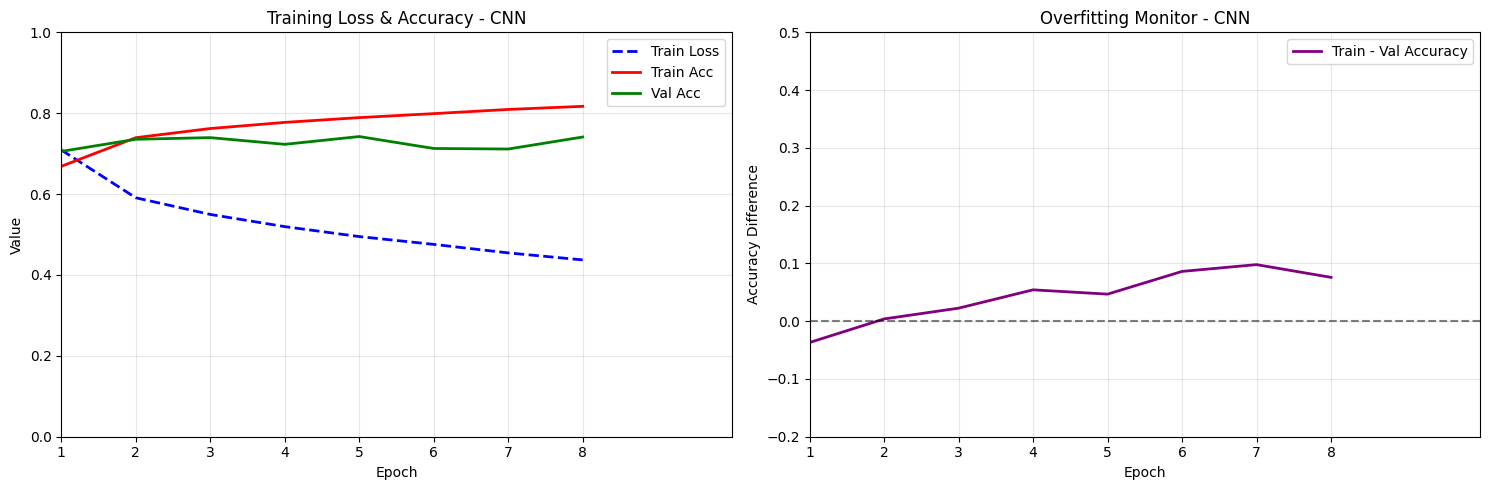


TRAINING SUMMARY
Model Name: CNN
Final Train Loss: 0.4372
Final Train Accuracy: 0.8170
Final Val Loss: 0.5968
Final Val Accuracy: 0.7412
Best Val Accuracy: 0.7423 (Epoch 5)
Final Overfitting Gap: 0.0759


In [70]:
# 绘制训练曲线
plot_training_curves("CNN", cnn_history)

# 打印训练摘要
print_training_summary("CNN", cnn_history)

Testing: 100%|██████████| 58491/58491 [00:58<00:00, 1005.87it/s]



TEST RESULTS
Model Name: CNN
Test Accuracy: 0.7428
Test Precision (weighted): 0.7478
Test Recall (weighted): 0.7428
Test F1 Score (weighted): 0.7436

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.8160    0.7074    0.7578     18596
     Neutral     0.6147    0.6633    0.6380     14754
    Positive     0.7754    0.8158    0.7951     25141

    accuracy                         0.7428     58491
   macro avg     0.7353    0.7288    0.7303     58491
weighted avg     0.7478    0.7428    0.7436     58491



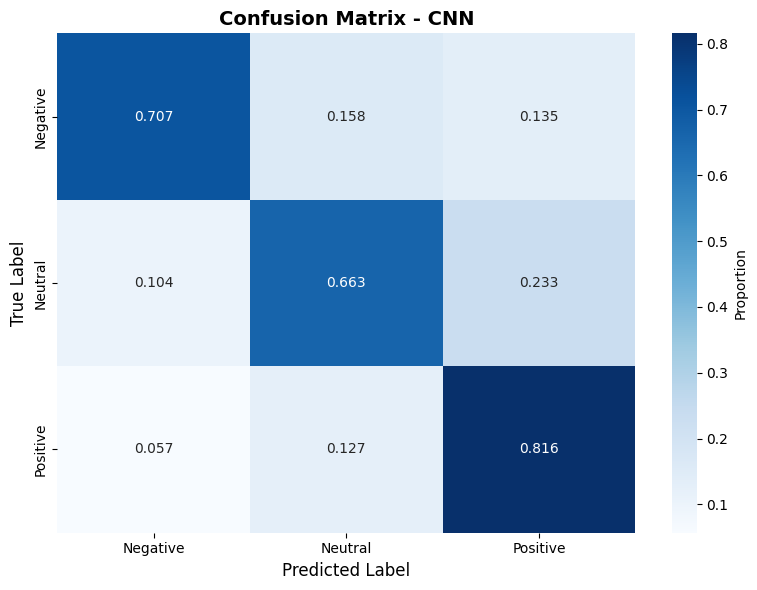


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.8160, Recall=0.7074, F1=0.7578, Support=18596
 Neutral: Precision=0.6147, Recall=0.6633, F1=0.6380, Support=14754
Positive: Precision=0.7754, Recall=0.8158, F1=0.7951, Support=25141


In [71]:
# CNN 测试过程 - 使用通用框架
cnn_test_results = test_model_comprehensive(
    model=cnn,
    model_name="CNN",
    test_loader=test_data_loader_cnn,
    device=device
)

In [72]:
# 保存CNN训练结果
save_training_results(
    model=cnn,
    model_name="CNN",
    set_epochs=num_epoch,
    actual_epochs=len(cnn_history['train_losses']),
    device=device,
    use_pretrained_embeddings=False,
    training_history=cnn_history,
    test_results=cnn_test_results,
)

✓ 训练结果已保存到 results/model_training_results.json
  - 模型: CNN (CNN)
  - 实际训练轮数: 8
  - 测试准确率: 0.7428
  - 测试F1分数: 0.7436
  - 记录时间: 2025-11-16 22:53:44
  - 总记录数: 18


### 长短时记忆网络

In [73]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn_lstm(batch):  #@save
    lengths = torch.tensor([len(b["text"]) for b in batch], dtype=torch.long)
    inputs = [torch.tensor(b["text"]) for b in batch]
    targets = torch.tensor([b["label"] for b in batch], dtype=torch.long)

    # 使用 pad_sequence 函数对输入序列进行填充
    inputs = pad_sequence(inputs, batch_first=True)

    return inputs, lengths, targets

In [74]:
from torch.nn.utils.rnn import pack_padded_sequence

class LSTM(nn.Module):  #@save
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_class, 
                 pretrained_embedding_matrix=None, freeze=True):
        super(LSTM, self).__init__()
        if pretrained_embedding_matrix:
            self.embeddings = nn.Embedding.from_pretrained(pretrained_embedding_matrix, freeze=freeze)
        else:
            self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, dropout=0.3, num_layers=2)

        self.dropout = nn.Dropout(0.5)
        
        self.output = nn.Linear(hidden_dim, num_class)

    def forward(self, inputs, lengths):
        embedding = self.embeddings(inputs)

        # 使用 pack_padded_sequence 函数对嵌入序列进行打包
        x_pack = pack_padded_sequence(embedding, lengths, batch_first=True, enforce_sorted=False)
        hidden, (hn, cn) = self.lstm(x_pack)
        output = self.dropout(hn[-1])
        output = self.output(output)
        return output

In [75]:
train_data_loader_lstm = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_lstm, shuffle=True)
test_data_loader_lstm = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_lstm, shuffle=False)

# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm = LSTM(len(vocab), embedding_dim, hidden_dim, num_class)
lstm.to(device)

LSTM(
  (embeddings): Embedding(35366, 200)
  (lstm): LSTM(200, 256, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.5, inplace=False)
  (output): Linear(in_features=256, out_features=3, bias=True)
)

In [76]:
# LSTM 训练过程 - 使用通用框架
weights = class_weights(train_tok)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)

# 创建验证数据加载器
val_data_loader_lstm = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_lstm, shuffle=False)

# 使用通用训练函数
lstm_history = train_model_with_validation(
    model=lstm,
    train_loader=train_data_loader_lstm,
    val_loader=val_data_loader_lstm,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device
)

Training Epoch 1: 100%|██████████| 8533/8533 [00:59<00:00, 142.54it/s]


Epoch 1/10
    Train Loss: 0.6564	Train Accuracy: 0.6984
    Valid Loss: 0.5776	Valid Accuracy: 0.7427
    Valid Precision: 0.7415	Valid Recall: 0.7427	Valid F1: 0.7393
    ✓ New best validation loss: 0.5776
--------------------------------------------------------------------------------


Training Epoch 2: 100%|██████████| 8533/8533 [00:56<00:00, 150.71it/s]


Epoch 2/10
    Train Loss: 0.5121	Train Accuracy: 0.7759
    Valid Loss: 0.5484	Valid Accuracy: 0.7554
    Valid Precision: 0.7574	Valid Recall: 0.7554	Valid F1: 0.7514
    ✓ New best validation loss: 0.5484
--------------------------------------------------------------------------------


Training Epoch 3: 100%|██████████| 8533/8533 [00:57<00:00, 147.50it/s]


Epoch 3/10
    Train Loss: 0.4296	Train Accuracy: 0.8162
    Valid Loss: 0.5589	Valid Accuracy: 0.7654
    Valid Precision: 0.7638	Valid Recall: 0.7654	Valid F1: 0.7637
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 4: 100%|██████████| 8533/8533 [00:57<00:00, 148.89it/s]


Epoch 4/10
    Train Loss: 0.3575	Train Accuracy: 0.8487
    Valid Loss: 0.5750	Valid Accuracy: 0.7592
    Valid Precision: 0.7603	Valid Recall: 0.7592	Valid F1: 0.7580
    No improvement. Patience: 2/3
--------------------------------------------------------------------------------


Training Epoch 5: 100%|██████████| 8533/8533 [00:56<00:00, 151.39it/s]


Epoch 5/10
    Train Loss: 0.2968	Train Accuracy: 0.8767
    Valid Loss: 0.6322	Valid Accuracy: 0.7569
    Valid Precision: 0.7606	Valid Recall: 0.7569	Valid F1: 0.7573
    No improvement. Patience: 3/3
    Early stopping triggered! Best validation loss: 0.5484


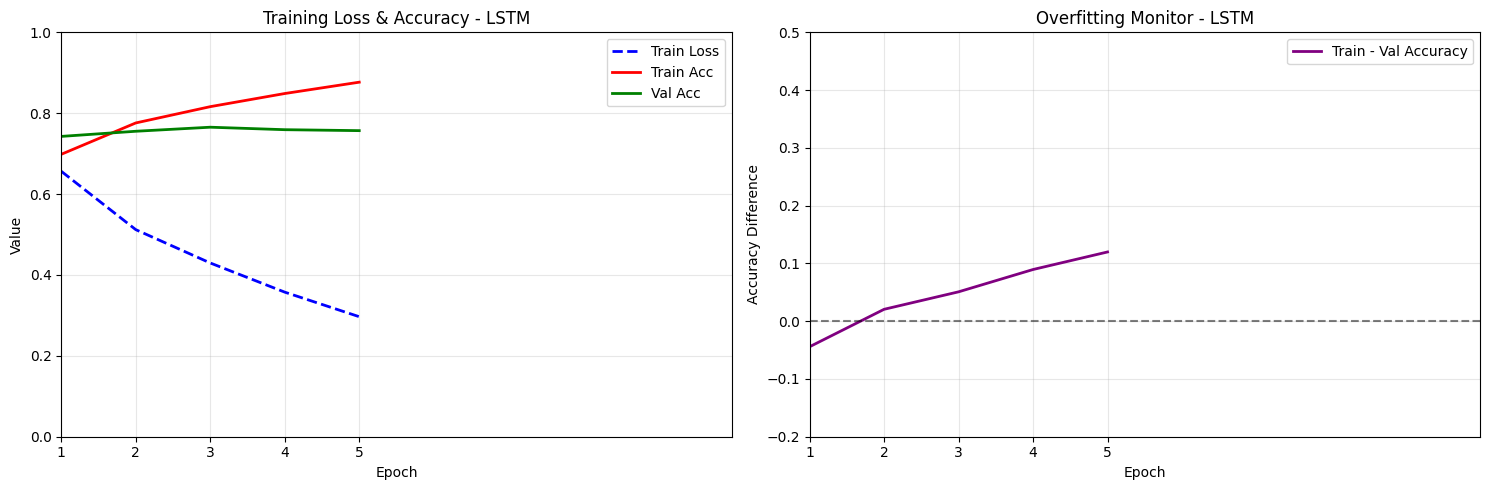


TRAINING SUMMARY
Model Name: LSTM
Final Train Loss: 0.2968
Final Train Accuracy: 0.8767
Final Val Loss: 0.6322
Final Val Accuracy: 0.7569
Best Val Accuracy: 0.7654 (Epoch 3)
Final Overfitting Gap: 0.1198


In [77]:
# 绘制训练曲线
plot_training_curves("LSTM", lstm_history)

# 打印训练摘要
print_training_summary("LSTM", lstm_history)

Testing: 100%|██████████| 58491/58491 [01:22<00:00, 708.17it/s]



TEST RESULTS
Model Name: LSTM
Test Accuracy: 0.7567
Test Precision (weighted): 0.7584
Test Recall (weighted): 0.7567
Test F1 Score (weighted): 0.7528

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.8326    0.7266    0.7760     18596
     Neutral     0.6926    0.5847    0.6341     14754
    Positive     0.7422    0.8800    0.8052     25141

    accuracy                         0.7567     58491
   macro avg     0.7558    0.7304    0.7384     58491
weighted avg     0.7584    0.7567    0.7528     58491



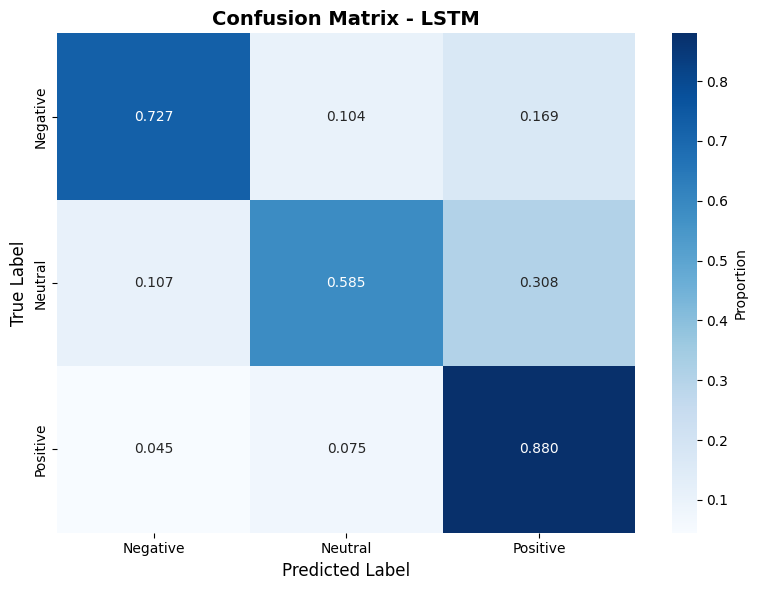


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.8326, Recall=0.7266, F1=0.7760, Support=18596
 Neutral: Precision=0.6926, Recall=0.5847, F1=0.6341, Support=14754
Positive: Precision=0.7422, Recall=0.8800, F1=0.8052, Support=25141


In [78]:
# LSTM 测试过程 - 使用通用框架
lstm_test_results = test_model_comprehensive(
    model=lstm,
    model_name="LSTM", 
    test_loader=test_data_loader_lstm,
    device=device
)

In [79]:
# 保存LSTM训练结果
save_training_results(
    model=lstm,
    model_name="LSTM",
    set_epochs=num_epoch,
    actual_epochs=len(lstm_history['train_losses']),
    device=device,
    use_pretrained_embeddings=False,
    training_history=lstm_history,
    test_results=lstm_test_results,
)

✓ 训练结果已保存到 results/model_training_results.json
  - 模型: LSTM (LSTM)
  - 实际训练轮数: 5
  - 测试准确率: 0.7567
  - 测试F1分数: 0.7528
  - 记录时间: 2025-11-16 23:00:21
  - 总记录数: 19


### Transformer

In [80]:
import math

def length_to_mask(lengths):  #@save
    max_len = torch.max(lengths)
    mask = torch.arange(max_len, device=lengths.device).expand(lengths.shape[0], max_len) < lengths.unsqueeze(1)
    return mask

class PositionalEncoding(nn.Module):  #@save
    def __init__(self, d_model, dropout=0.1, max_len=512):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.d_model = d_model

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)) / d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
        self.max_len = max_len

    def forward(self, x):
        # 如果输入序列长度超过预计算的位置编码长度，动态扩展位置编码
        seq_len = x.size(0)
        if seq_len > self.max_len:
            # 动态生成更长的位置编码
            pe_extended = torch.zeros(seq_len, self.d_model, device=x.device)
            position = torch.arange(0, seq_len, dtype=torch.float, device=x.device).unsqueeze(1)
            div_term = torch.exp(torch.arange(0, self.d_model, 2, dtype=torch.float, device=x.device) * 
                                (-math.log(10000.0)) / self.d_model)
            pe_extended[:, 0::2] = torch.sin(position * div_term)
            pe_extended[:, 1::2] = torch.cos(position * div_term)
            pe_extended = pe_extended.unsqueeze(0).transpose(0, 1)
            x = x + pe_extended[:seq_len, :]
        else:
            x = x + self.pe[:seq_len, :]
        
        return self.dropout(x)

In [81]:
class Transformer(nn.Module):  #@save
    def __init__(
            self, 
            vocab_size, 
            embedding_dim, 
            num_class, 
            dim_feedforward=512, 
            num_head=2, 
            num_layers=2, 
            dropout=0.1, 
            max_len=512, 
            activation: str = "relu", 
            pretrained_embedding_matrix=None, 
            freeze=True
            ):
        super(Transformer, self).__init__()
        self.embedding_dim = embedding_dim
        if pretrained_embedding_matrix:
            self.embeddings = nn.Embedding.from_pretrained(pretrained_embedding_matrix, freeze=freeze)
        else:
            self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.position_embedding = PositionalEncoding(embedding_dim, dropout, max_len)  # 位置编码

        encoder_layer = nn.TransformerEncoderLayer(embedding_dim, num_head, dim_feedforward, dropout, activation)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)

        self.output = nn.Linear(embedding_dim, num_class)

    def forward(self, inputs, lengths):
        inputs = torch.transpose(inputs, 0, 1)

        hidden_states = self.embeddings(inputs)
        hidden_states = self.position_embedding(hidden_states)

        lengths = lengths.to(inputs.device)
        attention_mask = length_to_mask(lengths) == False

        # 根据批次中每个序列长度生成 Mask 矩阵
        hidden_states = self.transformer(hidden_states, src_key_padding_mask=attention_mask)
        hidden_states = hidden_states[0, :, :]

        # 取第一个词元的输出结果作为分类层的输入
        outputs = self.output(hidden_states)
        return outputs

In [82]:
collate_fn_trans = collate_fn_lstm  #@save

In [83]:
train_data_loader_trans = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_trans, shuffle=True)
test_data_loader_trans = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_trans, shuffle=False)

# 加载模型（使用修复后的Transformer类）
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transformer = Transformer(len(vocab), embedding_dim, num_class, max_len=512)  # 明确指定max_len=512
transformer.to(device)

e:\anaconda3\envs\nlpllma\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer(
  (embeddings): Embedding(35366, 200)
  (position_embedding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=200, out_features=200, bias=True)
        )
        (linear1): Linear(in_features=200, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=200, bias=True)
        (norm1): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output): Linear(in_features=200, out_features=3, bias=True)
)

In [84]:
# Transformer 训练过程 - 使用通用框架
weights = class_weights(train_tok)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.001)

# 创建验证数据加载器
val_data_loader_trans = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_trans, shuffle=False)

# 使用通用训练函数
transformer_history = train_model_with_validation(
    model=transformer,
    train_loader=train_data_loader_trans,
    val_loader=val_data_loader_trans,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device
)

Training Epoch 1: 100%|██████████| 8533/8533 [03:08<00:00, 45.21it/s]


Epoch 1/10
    Train Loss: 0.8721	Train Accuracy: 0.5572
    Valid Loss: 0.8064	Valid Accuracy: 0.6129
    Valid Precision: 0.6190	Valid Recall: 0.6129	Valid F1: 0.6041
    ✓ New best validation loss: 0.8064
--------------------------------------------------------------------------------


Training Epoch 2: 100%|██████████| 8533/8533 [03:00<00:00, 47.34it/s]


Epoch 2/10
    Train Loss: 0.8160	Train Accuracy: 0.6061
    Valid Loss: 0.7792	Valid Accuracy: 0.6358
    Valid Precision: 0.6338	Valid Recall: 0.6358	Valid F1: 0.6225
    ✓ New best validation loss: 0.7792
--------------------------------------------------------------------------------


Training Epoch 3: 100%|██████████| 8533/8533 [02:59<00:00, 47.60it/s]


Epoch 3/10
    Train Loss: 0.7718	Train Accuracy: 0.6401
    Valid Loss: 0.7563	Valid Accuracy: 0.6559
    Valid Precision: 0.6553	Valid Recall: 0.6559	Valid F1: 0.6555
    ✓ New best validation loss: 0.7563
--------------------------------------------------------------------------------


Training Epoch 4: 100%|██████████| 8533/8533 [02:48<00:00, 50.51it/s]


Epoch 4/10
    Train Loss: 0.7451	Train Accuracy: 0.6581
    Valid Loss: 0.7264	Valid Accuracy: 0.6636
    Valid Precision: 0.6659	Valid Recall: 0.6636	Valid F1: 0.6594
    ✓ New best validation loss: 0.7264
--------------------------------------------------------------------------------


Training Epoch 5: 100%|██████████| 8533/8533 [02:56<00:00, 48.38it/s]


Epoch 5/10
    Train Loss: 0.7273	Train Accuracy: 0.6658
    Valid Loss: 0.7331	Valid Accuracy: 0.6607
    Valid Precision: 0.6586	Valid Recall: 0.6607	Valid F1: 0.6515
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 6: 100%|██████████| 8533/8533 [02:07<00:00, 67.07it/s]


Epoch 6/10
    Train Loss: 0.7065	Train Accuracy: 0.6800
    Valid Loss: 0.7188	Valid Accuracy: 0.6794
    Valid Precision: 0.6798	Valid Recall: 0.6794	Valid F1: 0.6726
    ✓ New best validation loss: 0.7188
--------------------------------------------------------------------------------


Training Epoch 7: 100%|██████████| 8533/8533 [02:00<00:00, 71.04it/s]


Epoch 7/10
    Train Loss: 0.7108	Train Accuracy: 0.6790
    Valid Loss: 0.7316	Valid Accuracy: 0.6693
    Valid Precision: 0.6711	Valid Recall: 0.6693	Valid F1: 0.6682
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 8: 100%|██████████| 8533/8533 [02:24<00:00, 58.87it/s]


Epoch 8/10
    Train Loss: 0.6854	Train Accuracy: 0.6942
    Valid Loss: 0.7239	Valid Accuracy: 0.6831
    Valid Precision: 0.6802	Valid Recall: 0.6831	Valid F1: 0.6793
    No improvement. Patience: 2/3
--------------------------------------------------------------------------------


Training Epoch 9: 100%|██████████| 8533/8533 [02:50<00:00, 50.08it/s]


Epoch 9/10
    Train Loss: 0.6842	Train Accuracy: 0.6977
    Valid Loss: 0.7114	Valid Accuracy: 0.6835
    Valid Precision: 0.6810	Valid Recall: 0.6835	Valid F1: 0.6799
    ✓ New best validation loss: 0.7114
--------------------------------------------------------------------------------


Training Epoch 10: 100%|██████████| 8533/8533 [02:23<00:00, 59.47it/s]


Epoch 10/10
    Train Loss: 0.6660	Train Accuracy: 0.7074
    Valid Loss: 0.6942	Valid Accuracy: 0.6923
    Valid Precision: 0.6909	Valid Recall: 0.6923	Valid F1: 0.6888
    ✓ New best validation loss: 0.6942
--------------------------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative     0.7416    0.6547    0.6954     18605
     Neutral     0.6004    0.5388    0.5679     14727
    Positive     0.7063    0.8101    0.7546     25134

    accuracy                         0.6923     58466
   macro avg     0.6828    0.6678    0.6727     58466
weighted avg     0.6909    0.6923    0.6888     58466



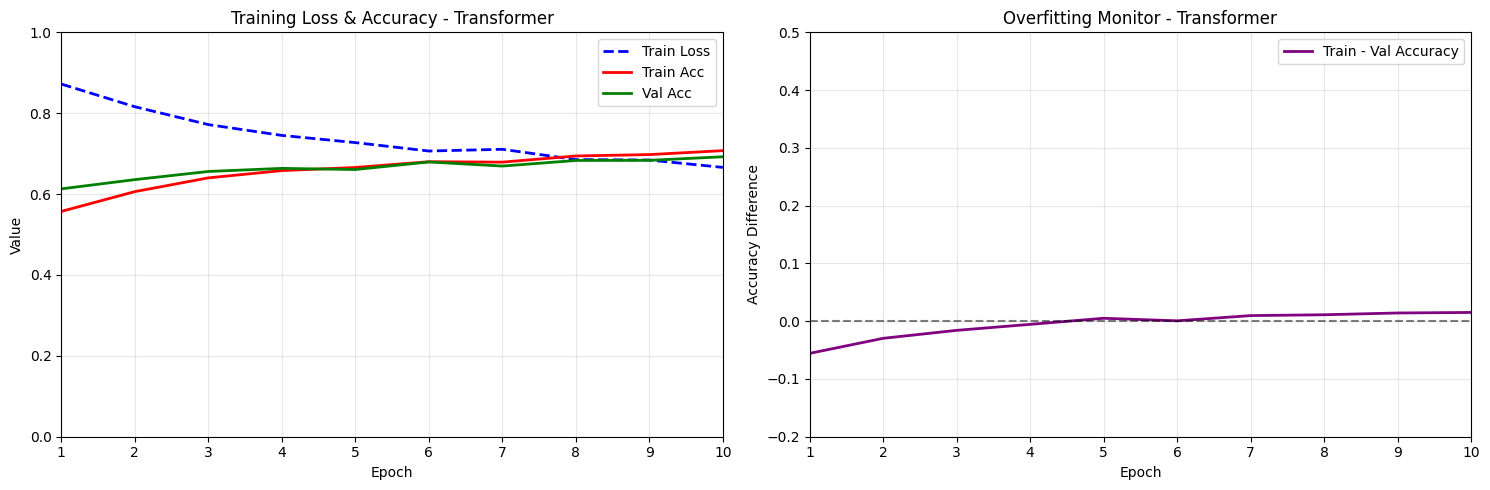


TRAINING SUMMARY
Model Name: Transformer
Final Train Loss: 0.6660
Final Train Accuracy: 0.7074
Final Val Loss: 0.6942
Final Val Accuracy: 0.6923
Best Val Accuracy: 0.6923 (Epoch 10)
Final Overfitting Gap: 0.0151


In [85]:
# 绘制训练曲线
plot_training_curves("Transformer", transformer_history)

# 打印训练摘要
print_training_summary("Transformer", transformer_history)

Testing: 100%|██████████| 58491/58491 [03:39<00:00, 266.48it/s]



TEST RESULTS
Model Name: Transformer
Test Accuracy: 0.6954
Test Precision (weighted): 0.6941
Test Recall (weighted): 0.6954
Test F1 Score (weighted): 0.6921

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.7488    0.6646    0.7042     18596
     Neutral     0.6025    0.5396    0.5693     14754
    Positive     0.7075    0.8097    0.7551     25141

    accuracy                         0.6954     58491
   macro avg     0.6863    0.6713    0.6762     58491
weighted avg     0.6941    0.6954    0.6921     58491



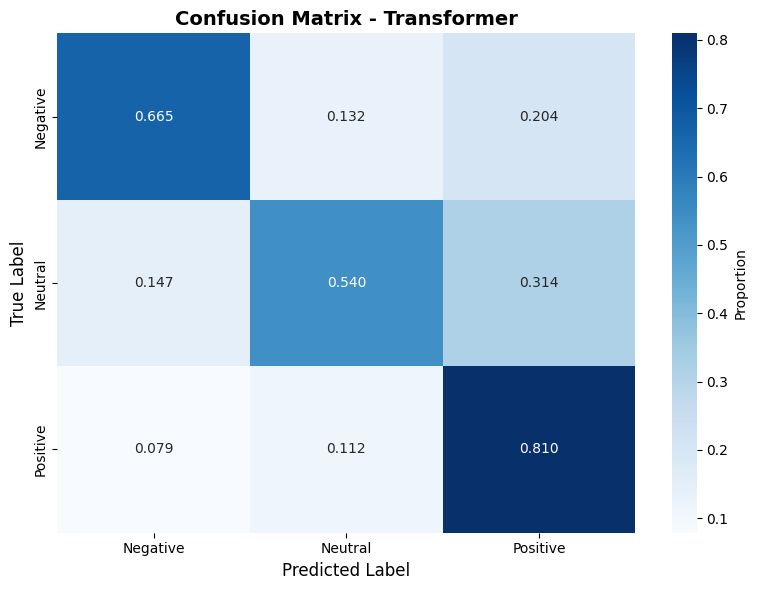


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.7488, Recall=0.6646, F1=0.7042, Support=18596
 Neutral: Precision=0.6025, Recall=0.5396, F1=0.5693, Support=14754
Positive: Precision=0.7075, Recall=0.8097, F1=0.7551, Support=25141


In [86]:
# Transformer 测试过程 - 使用通用框架
transformer_test_results = test_model_comprehensive(
    model=transformer,
    model_name="Transformer",
    test_loader=test_data_loader_trans,
    device=device
)

In [87]:
# 保存Transformer训练结果
save_training_results(
    model=transformer,
    model_name="Transformer",
    set_epochs=num_epoch,
    actual_epochs=len(transformer_history['train_losses']),
    device=device,
    use_pretrained_embeddings=False,
    training_history=transformer_history,
    test_results=transformer_test_results,
)

✓ 训练结果已保存到 results/model_training_results.json
  - 模型: Transformer (Transformer)
  - 实际训练轮数: 10
  - 测试准确率: 0.6954
  - 测试F1分数: 0.6921
  - 记录时间: 2025-11-16 23:32:18
  - 总记录数: 20


In [88]:
# 模型性能比较
def compare_models(model_results, model_names=None):
    """
    比较多个模型的性能
    
    Args:
        model_results: 模型结果字典的列表
        model_names: 模型名称列表
    """
    if model_names is None:
        model_names = [f"Model {i+1}" for i in range(len(model_results))]
    
    # 创建比较表格
    import pandas as pd
    
    comparison_data = []
    for i, (name, result) in enumerate(zip(model_names, model_results)):
        comparison_data.append({
            'Model': name,
            'Accuracy': result['accuracy'],
            'Precision': result['precision'],
            'Recall': result['recall'],
            'F1 Score': result['f1']
        })
    
    df = pd.DataFrame(comparison_data)
    print("\n" + "="*80)
    print("MODEL PERFORMANCE COMPARISON")
    print("="*80)
    print(df.round(4).to_string(index=False))
    
    # 绘制比较图表
    plt.figure(figsize=(15, 5))
    
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    metric_keys = ['accuracy', 'precision', 'recall', 'f1']  # 对应的字典键
    x = np.arange(len(model_names))
    width = 0.2
    
    plt.subplot(1, 2, 1)
    for i, (metric, key) in enumerate(zip(metrics, metric_keys)):
        values = [result[key] for result in model_results]
        plt.bar(x + i*width, values, width, label=metric, alpha=0.8)
    
    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x + width*1.5, model_names)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0.5, 0.9)
    
    # F1分数单独比较
    plt.subplot(1, 2, 2)
    f1_scores = [result['f1'] for result in model_results]
    bars = plt.bar(model_names, f1_scores, alpha=0.8, color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum'][:len(model_names)])
    plt.xlabel('Models')
    plt.ylabel('F1 Score')
    plt.title('F1 Score Comparison')
    plt.grid(True, alpha=0.3)
    plt.ylim(0.5, 0.9)
    
    # 在柱状图上显示数值
    for bar, score in zip(bars, f1_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{score:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # 找出最佳模型
    best_idx = np.argmax([result['f1'] for result in model_results])
    print(f"\nBest performing model: {model_names[best_idx]} (F1 Score: {model_results[best_idx]['f1']:.4f})")

# 使用示例（在所有模型都训练完成后运行）
model_results = [
    logreg_test_results,  # Logistic Regression
    mlp_test_results,  # MLP
    cnn_test_results,  # CNN  
    lstm_test_results,  # LSTM
    transformer_test_results  # Transformer
]
model_names = ['TF-IDF + LR', 'MLP', 'CNN', 'LSTM', 'Transformer']
# compare_models(model_results, model_names)